# 1. [65] Authentication in a service

## 1.1. [25] What do you store in your Google Drive?

Sometimes it can be quite troublesome to crawl web data - for example, when you can't just collect data from web-pages because the authentification to a website is required. Today's tutorial is about a dataset of special type - namely, Google Drive data. You will need to get access to the system using OAuth protocol, download and parse files of different types.

Plan. 
1. Download [this little archive](https://drive.google.com/open?id=1Xji4A_dEAm_ycnO0Eq6vxj7ThcqZyJZR), **unzip** it and place the folder anywhere inside your Google Drive. You should get a subtree of 6 folders with files of different types: presentations, pdf-files, texts, and even code.
2. Go to [Google Drive API](https://developers.google.com/drive/api/v3/quickstart/python) documentation, read [intro](https://developers.google.com/drive/api/v3/about-sdk) and learn how to [search for files](https://developers.google.com/drive/api/v3/reference/files/list) and [download](https://developers.google.com/drive/api/v3/manage-downloads) them. Pay attention, that  working at `localhost` (jupyter) and at `google colab` can be slighty different. We expect you to run from localhost.
3. Learn how to open from python such files as [pptx](https://python-pptx.readthedocs.io/en/latest/user/quickstart.html), pdf, docx or even use generalized libraries like [textract](https://textract.readthedocs.io/en/stable/index.html), save internal text in a file near.
4. Write a code with returns names (with paths) of files for a given substring. Test on these queries.
```
segmentation
algorithm
classifer
printf
predecessor
Шеннон
Huffman
function
constructor
machine learning
dataset
Протасов
Protasov
```

### 1.1.1. Access GDrive ###

Below is the example of how you can oranize your code - it's fine if you change it.

Let's extract the list of all files that are contained (recursively) in the folder of interest.

Refer to API:
- [/list files](https://developers.google.com/drive/api/v3/reference/files#resource)
- Use `webContentLink` property or [/get](https://developers.google.com/drive/api/v3/reference/files/get) method to download content.

In [7]:
# install some dependencies
!pip uninstall -y textract tensorflow google-api-python-client google-auth-httplib2 google-auth-oauthlib six google-api-core tensorboard
!pip install six==1.15.0
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

Found existing installation: textract 1.6.3
Uninstalling textract-1.6.3:
  Successfully uninstalled textract-1.6.3
Found existing installation: six 1.12.0
Uninstalling six-1.12.0:
  Successfully uninstalled six-1.12.0
Defaulting to user installation because normal site-packages is not writeable
  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)
Defaulting to user installation because normal site-packages is not writeable
  Using cached google_api_python_client-2.1.0-py2.py3-none-any.whl (6.6 MB)
  Using cached google_auth_httplib2-0.1.0-py2.py3-none-any.whl (9.3 kB)
  Using cached google_auth_oauthlib-0.4.4-py2.py3-none-any.whl (18 kB)
  Using cached google_api_core-1.26.3-py2.py3-none-any.whl (93 kB)


In [8]:
import importlib
import six
importlib.reload(six)

import os.path
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
  
# Define the SCOPES
SCOPES = ['https://www.googleapis.com/auth/drive']

service = None
creds = None
if os.path.exists('token.json'):
    creds = Credentials.from_authorized_user_file('token.json', SCOPES)

# If there are no (valid) credentials available, let the user log in.

# if not creds or not creds.valid:
#     if creds and creds.expired and creds.refresh_token:
#         creds.refresh(Request())
#         print("REFRESHED")
#     else:
#         flow = InstalledAppFlow.from_client_secrets_file(
#             'credentials.json', SCOPES)
#         creds = flow.run_local_server(port=0)
#     # Save the credentials for the next run
#     with open('token.json', 'w') as token:
#         token.write(creds.to_json())

service = build('drive', 'v3', credentials=creds)
print("Successfully created a service")

Successfully created a service


In [9]:
import io
from googleapiclient.http import MediaIoBaseDownload
resource = service.files()
def search_with_query(query):
    page_token = None
    files = []
    while True:
        response = resource.list(q=query,
                                 fields='nextPageToken, files(id, name)',
                                 pageToken=page_token).execute()
        
        files = files + response.get('files', [])
        page_token = response.get('nextPageToken', None)
        if page_token is None:
            break
    return files

def gdrive_get_all_files_in_folder(folder_name):
    #TODO retrieve all file information from a given folder   
    # refer to API for details https://developers.google.com/drive/api/v3/reference/files#resource 
    # response can be the list of any type metadata (ids, dictionaries, ...)
    result = resource.list(fields="files(id, name, parents, mimeType)").execute()
    gdrive_file_list = result.get('files')
    target_folder = search_with_query("name='{}'".format(folder_name))
    
    if len(target_folder)!=1:
        if len(target_folder)>1:
            raise Exception("More than one {} folder was found".format(folder_name))
        else:
            raise Exception("No folder named {} was found".format(folder_name))
    
    target_id = target_folder[0]['id']
    file_list = search_with_query("'{}' in parents and mimeType != 'application/vnd.google-apps.folder'".format(target_id))
    
    folder_list = search_with_query("'{}' in parents and mimeType = 'application/vnd.google-apps.folder'".format(target_id))

    while True:
        if len(folder_list)==0:
            break
        else:
            folder_id = folder_list[0]['id']
            folder_list.pop(0)

            new_folder_list = search_with_query("'{}' in parents and mimeType = 'application/vnd.google-apps.folder'".format(folder_id))
            folder_list = folder_list + new_folder_list
            
            new_file_list = search_with_query("'{}' in parents and mimeType != 'application/vnd.google-apps.folder'".format(folder_id))
            file_list = file_list + new_file_list
    
    formatted_file_list = []
    for file in file_list:
        formatted_file_list.append([file['id'],file['name']])
        
    return formatted_file_list

def gdrive_download_file(file, folder_to_save): 
    #TODO download file and save it in `folder_to_save` folder
    file_id = file[0]
    filename = file[1]
    if not os.path.exists(folder_to_save):
        os.mkdir(folder_to_save)
    request = resource.get_media(fileId=file_id)
    if os.path.exists(os.path.join(folder_to_save, filename)):
        print("File {} already exists in {}. \nIt was not downloaded again".format(filename,folder_to_save))
        pass
    else:
        fh = io.FileIO(os.path.join(folder_to_save, filename), 'wb')
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while done is False:
            status, done = downloader.next_chunk()
            print ("Download %d%%." % int(status.progress() * 100))
    pass

In [10]:
# specify your folder name
folder_of_interest = 'data'

files = gdrive_get_all_files_in_folder(folder_of_interest)

test_dir = "test_files"   # we save the data here
for item in files:
    gdrive_download_file(item, test_dir)

File hockey.avi already exists in test_files. 
It was not downloaded again
File at least this file.txt already exists in test_files. 
It was not downloaded again
File deep-features-scene (1).pdf already exists in test_files. 
It was not downloaded again
File grant-translate.txt already exists in test_files. 
It was not downloaded again
File grant.txt already exists in test_files. 
It was not downloaded again
File Small dataset face recognition.pptx already exists in test_files. 
It was not downloaded again
File students.txt already exists in test_files. 
It was not downloaded again
File Tutorial 9.pdf already exists in test_files. 
It was not downloaded again
File Assessment Criteria (May).pdf already exists in test_files. 
It was not downloaded again
File AY16-17 Academic Calendar .pdf already exists in test_files. 
It was not downloaded again
File retake-2016-08-18.docx already exists in test_files. 
It was not downloaded again
File dsa.pdf already exists in test_files. 
It was not d

### 1.1.2. Tests ###
Please fill free to change function signatures and behaviour. Please do not change asserts.

In [11]:
assert len(files) == 34, 'Number of files is incorrect'
print('n_files:', len(files))

print("file here means id and name, e.g.: ", files[0])

gdrive_download_file(files[0], '.')

import os.path
assert os.path.isfile(os.path.join('.', files[0][1])), "File is not downloaded correctly"

n_files: 34
file here means id and name, e.g.:  ['1UJEZz4alGqtZWwT0NUcHvsRluEw5yLgJ', 'hockey.avi']
File hockey.avi already exists in .. 
It was not downloaded again


## 1.2. [20] Read files content
### 1.2.1. Read

In [12]:
# install dependencies
!pip uninstall -y textract tensorflow google-api-python-client google-auth-httplib2 google-auth-oauthlib six google-api-core tensorboard
!pip install chardet six==1.12.0
!pip install textract

Found existing installation: google-api-python-client 2.1.0
Uninstalling google-api-python-client-2.1.0:
  Successfully uninstalled google-api-python-client-2.1.0
Found existing installation: google-auth-httplib2 0.1.0
Uninstalling google-auth-httplib2-0.1.0:
  Successfully uninstalled google-auth-httplib2-0.1.0
Found existing installation: google-auth-oauthlib 0.4.4
Uninstalling google-auth-oauthlib-0.4.4:
  Successfully uninstalled google-auth-oauthlib-0.4.4
Found existing installation: six 1.15.0
Uninstalling six-1.15.0:
  Successfully uninstalled six-1.15.0
Found existing installation: google-api-core 1.26.3
Uninstalling google-api-core-1.26.3:
  Successfully uninstalled google-api-core-1.26.3
Defaulting to user installation because normal site-packages is not writeable
  Using cached six-1.12.0-py2.py3-none-any.whl (10 kB)
Defaulting to user installation because normal site-packages is not writeable
  Using cached textract-1.6.3-py3-none-any.whl (21 kB)


For windows please refer to:
- [textract docs](https://textract.readthedocs.io/en/latest/installation.html#don-t-see-your-operating-system-installation-instructions-here)
- [xpdf reader docs](https://www.xpdfreader.com/download.html)

**NB**: BE CAREFUL WITH SPACES IN NAMES. Better save without spaces in names.

In [20]:
import importlib
import six
importlib.reload(six)

import textract 
import chardet
import os
import unicodedata

def apply_textract(path):
    texts = None
    
    try:
        texts = textract.process(path)
    except:
        try:
            texts = textract.process(path, method='pdfminer')
        except:
            texts = textract.process(path, method='tesseract')
            
    if texts is None:
        return texts
    else:
        texts = texts.decode('utf-8')
        texts = unicodedata.normalize('NFKD', texts)
        return texts.replace('\\n', '\n').replace('\\r', '').split('\n')
        
def apply_textract_txt(path):
    texts = None
    try:
        texts = textract.process(path,extension='txt')
    except:
        pass
    if texts is None:
        return texts
    else:
        texts = texts.decode('utf-8')
        texts = unicodedata.normalize('NFKD', texts)
        return texts.replace('\\n', '\n').replace('\\r', '').split('\n')
    
def parse_audio(path):
    return None

def parse_video(path):
    return None

def get_file_strings(path):
    texts = None
    ext = os.path.splitext(path)[1].strip()
    
    if ext in ['.mp3','.wav','.ogg']:
        texts = parse_audio(path)
        return texts
    
    if ext in ['.avi','.mp4','.mov']:
        texts = parse_video(path)
        return texts
    
    try:
        texts = apply_textract(path)
        if texts is not None:
            return texts
    except:
        pass

    try:
        os.rename(path,os.path.splitext(path)[0].strip())
        texts = apply_textract_txt(os.path.splitext(path)[0].strip())
        os.rename(os.path.splitext(path)[0].strip(),path)
        if texts is not None:
            return texts
    except:
        try:
            os.rename(os.path.splitext(path)[0].strip(),path)
        except:
            pass
    
    try:
        texts = open(path, 'rb').read()
        encode = chardet.detect(texts)['encoding']
        with open(path, encoding=encode) as file:
            texts = file.read()
            return texts.replace('\\n', '\n').replace('\\r', '').split('\n')
    except:
        pass

    
    return texts


In [ ]:
# creating dictionary of parsed files
files_data = dict()
for file in os.scandir(test_dir): 
    strings = get_file_strings(file.path)
    if strings:
        files_data[file.name] = strings

### 1.2.2. Tests for read

In [15]:
print(len(files_data))
assert len(files_data) == 31 


assert "Protasov" in get_file_strings(os.path.join(test_dir, 'at least this file.txt')), "TXT File parsed incorrectly"
assert "A. Image classification" in get_file_strings(os.path.join(test_dir, 'deep-features-scene (1).pdf')), "PDF File parsed incorrectly"

31


## 1.3. [20] Tests

In [18]:
def find(query):
    #TODO implement search procedure
    results = []
    for key in files_data.keys():
        if query in key:
            results.append(key)
        else:
            for line in files_data[key]:
                if query in line:
                    results.append(key)
                    break
    return results

In [19]:
queries = ["segmentation", "algorithm", "printf", "predecessor", "Huffman",
           "function", "constructor", "machine learning", "dataset", "Protasov"]

for query in queries:
    r = find(query)
#     print("Results for: ", query)
#     print("\t", r)
    assert len(r) > 0, "Query should return at least 1 document"
    assert len(r) > 1, "Query should return at least 2 documents"
    assert "at least this file.txt" in r, "This file has all the queries. It should be in a result"

# 2. [35] Parse me if you can #

Sometimes when crawling we have to parse websites that turn out to be SaaS - i.e., there is a special JS application which renders documents and which is downloaded first. Therefore, data that is to be rendered initially comes in a proprietary format. One of the examples is Google Drive. Last time we downladed and parsed some files from GDrive, however, we didn't parse GDrive-specific file formats, such as google sheets or google slides.

Today we will learn to obtain and parse such data using Selenium - a special framework for testing web-applications.

## 2.1. [5] Getting started

Let's try to load and parse the page the way we did before:

In [1]:
import requests
from bs4 import BeautifulSoup
resp = requests.get("https://docs.google.com/presentation/d/1LuZvz3axBD8UuHLagdv0EbhsGEWJmpd7gN5KjwYCp9Y/edit?usp=sharing")
soup = BeautifulSoup(resp.text, 'lxml')
print(soup.body.text[:1000])

Не удалось открыть файл, поскольку в вашем браузере отключено использование JavaScript. Включите его и перезагрузите страницу.Некоторые функции PowerPoint не поддерживаются в Google Презентациях. Они будут удалены, если вы измените документ.Подробнее…6. Approximate nearest neighbours search 2. Trees   Смотреть  Открыть доступВойтиИспользуемая вами версия браузера больше не поддерживается. Установите поддерживаемую версию браузера.Закрытьdocument.getElementById('docs-unsupported-browser-bar').addEventListener('click', function () {this.parentNode.parentNode.removeChild(this.parentNode);return false;});ФайлПравкаВидСправкаСпециальные возможностиОтладкаНесохраненные изменения: ДискПоследние изменения      Специальные возможности  Только просмотр     DOCS_timing['che'] = new Date().getTime();DOCS_timing['chv'] = new Date().getTime();Презентация в виде HTML(function(){/*

 Copyright The Closure Library Authors.
 SPDX-License-Identifier: Apache-2.0
*/
var a=this||self;function c(b){this.i=b;

As we see, the output is not what we expect. So, what can we do when a page is not being loaded right away, but is rather rendered by a script? Browser engines can help us get data. Let's try to load the same web-page, but do it in a different way: let's give some time to a browser to load the scripts and run them; and then will work with DOM (Document Object Model), but will get it from browser engine itself, not from BeautifulSoup.

Where do we get browser engine from? Simply installing a browser will do the thing. How do we send commands to it from code and retrieve DOM? Service applications called drivers will interpret out commands and translate them into browser actions.


For each browser engine suport you will need to:
1. install browser itself;
2. download 'driver' - binary executable, which passed commands from selenium to browser. E.g. [Gecko == Firefox](https://github.com/mozilla/geckodriver/releases), [ChromeDriver](http://chromedriver.storage.googleapis.com/index.html);
3. unpack driver into a folder under PATH environment variable. Or specify exact binary location.

### 2.1.1. Download driver

And place it in any folder or under PATH env. variable.

### 2.1.2. Install selenium

In [2]:
!pip install -U selenium

Defaulting to user installation because normal site-packages is not writeable


In [3]:
from selenium import webdriver

### 2.1.3. Launch browser

This will open browser window

In [4]:
browser = webdriver.Firefox()
# or explicitly
# browser = webdriver.Firefox(
#     executable_path='/home/olya/Downloads/IR/hw2/geckodriver', 
#     firefox_binary='/usr/bin/firefox'
# )

### 2.1.4. Download the page


In [6]:
# navigate to page
browser.get('http://tiny.cc/00dhkz')
browser.implicitly_wait(5)  # wait 5 seconds

# select all text parts from document
elements = browser.find_elements_by_css_selector("g.sketchy-text-content-text")
# note that if number differs from launch to launch this means better extend wait time
print("Elements found:", len(elements))

# oh no! It glues all the words!
print("What if just a silly approach:", elements[0].text)

# GDrive stores all text blocks word-by-word
subnodes = elements[0].find_elements_by_css_selector("text")
text = " ".join(n.text for n in subnodes)
print("What if a smart approach:", text)

Elements found: 126
What if just a silly approach: Forestsofsearchtrees
What if a smart approach: Forests of search trees


In [7]:
browser.quit()

- Too slow, wait for browser to open, browser to render

## 2.2. Headless

Browsers (at least [FF](https://developer.mozilla.org/en-US/docs/Mozilla/Firefox/Headless_mode), [Chrome](https://intoli.com/blog/running-selenium-with-headless-chrome/), IE) have headless mode - no window rendering and so on. Means it should work much faster!

In [22]:
!echo $PATH
options = webdriver.FirefoxOptions()
options.add_argument('-headless')
options.add_argument('-window-size=1200x600')
#browser = webdriver.Firefox(executable_path='/home/olya/Downloads/IR/hw2/geckodriver', 
#    firefox_binary='/usr/bin/firefox',options=options)
browser = webdriver.Firefox(options=options)

/home/olya/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin


In [9]:
## SAME CODE

# navigate to page
browser.get('http://tiny.cc/00dhkz')
browser.implicitly_wait(5)  # wait 5 seconds

# select all text parts from document
elements = browser.find_elements_by_css_selector("g.sketchy-text-content-text")
# note that if number differs from launch to launch this means better extend wait time
print("Elements found:", len(elements))

# oh no! It adds NEW LINE. Behavior differs!!!!
print("What if just a silly approach:", elements[0].text)

# GDrive stores all text blocks word-by-word
subnodes = elements[0].find_elements_by_css_selector("text")
text = " ".join(n.text for n in subnodes)
print("What if a smart approach:", text)

Elements found: 110
What if just a silly approach: Forestsofsearchtrees
What if a smart approach: Forests of search trees


In [24]:
browser.quit()

## 2.3. [30] Show me what it hides

The task shows that dynamic rendering of the web page (which includes javascript execution and remote content loading) can significantly influence page content. That is why when you index such page you'd better rely in what user will see, rather than html page content.

Your task is to process the page *after* it is rendered with a browser, and extract all image urls. The test will draw the images, they should sum up into a single picture like in example.

In [19]:
def get_url_images(url):
    '''This function finds all `img` tags at the page, given by `url`. It returns the [list] of `absolute` image urls'''
    #TODO: write your code here
    #source: https://pythonspot.com/selenium-get-images/
    images = []
    try:
        browser.get(url)
        browser.implicitly_wait(5)
    except:
        return images

    for image in browser.find_elements_by_tag_name('img'):
        images.append(image.get_attribute('src'))
    return images

### 2.3.1. Tests

Results of the tests whould be the image displayed below the code.

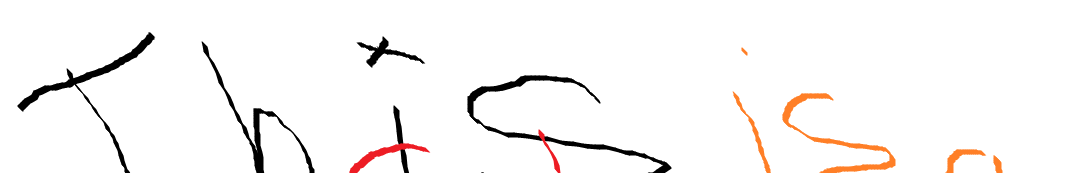

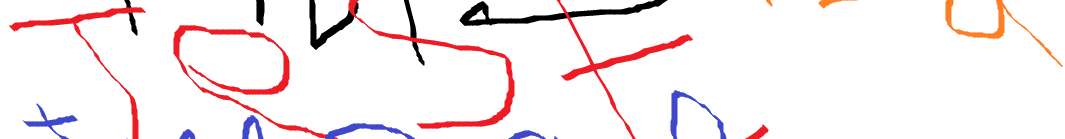

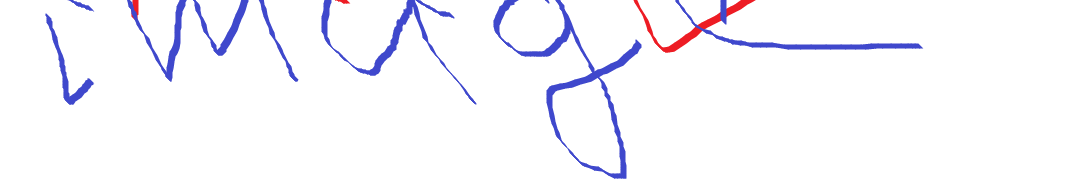

In [20]:
from IPython.display import Image, display

test_urls = [
    "http://sprotasov.ru/files/AIR/2a/simple_static.html",
    "http://sprotasov.ru/files/AIR/2a/simple_dynamic.html",
    "http://sprotasov.ru/files/AIR/2a/trick_dynamic.html"
]

for url in test_urls:
    for img in get_url_images(url):
        display(Image(img, width=500))